# Титаник

## Зареждане на необходимите библиотеки

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion

from IPython.display import display

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [14]:
# Loading the data
train = pd.read_csv('data/titanic-train.csv', index_col='PassengerId')
test = pd.read_csv('data/titanic-test.csv', index_col='PassengerId')

full_data = [train, test]

# Lets have a look at the data
train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Getting to know the data

In [15]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some of the **age** rows are empty, we weould need to **implant** some data there.

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [17]:
for data in full_data:
    print(data.isnull().sum().sort_values())

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Embarked      0
Fare          1
Age          86
Cabin       327
dtype: int64


Трябва да попълним липсващите данни, но преди това...

## Базови модели

In [18]:
X = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y = train['Survived']

X['Age'].fillna(X['Age'].mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y)

In [19]:
lr_model = LogisticRegression().fit(X_train, y_train)
rf_model = RandomForestClassifier().fit(X_train, y_train)
svc_model = SVC(C=1).fit(X_train, y_train)

print("logistic recression train score:", lr_model.score(X_train, y_train))
print("logistic recression test score: ", lr_model.score(X_test, y_test), end='\n\n')

print("random forest train score:", rf_model.score(X_train, y_train))
print("random forest recression test score: ", rf_model.score(X_test, y_test), end='\n\n')

print("support vector classifier score:", svc_model.score(X_train, y_train))
print("support vector classifier score: ", svc_model.score(X_test, y_test), end='\n\n')

logistic recression train score: 0.693113772455
logistic recression test score:  0.744394618834

random forest train score: 0.929640718563
random forest recression test score:  0.699551569507

support vector classifier score: 0.862275449102
support vector classifier score:  0.659192825112



Доста овърфит при svm и random forest класификаторите.

# Малко помощни класове

Този клас ще one-hot-encode-ва стрингови (категорийни) фийчъри. Подходящ е за pipeline-ове.

In [20]:
class StringLabelBinerizer(LabelBinarizer):
    def __init__(self, prefix='col', key=lambda x: x, **kwargs):
        self.prefix = prefix
        self.key = key
        super(StringLabelBinerizer, self).__init__(**kwargs)
    
    def map_input(self, y):
        return y

    def fit(self, y, prefix='col', key=lambda x: x):
        self.key = key
        return super(StringLabelBinerizer, self).fit(self.map_input(y))

    def transform(self, y):
        cols = list(map(lambda s: self.prefix + '_' + s, self.classes_))
        if len(cols) == 2:
            cols = [self.prefix]
        result = pd.DataFrame(super(StringLabelBinerizer, self).transform(self.map_input(y)), columns=cols)
        result.index += 1
        return result
        
    def fit_transform(self, y, *_):
        self.fit(y)
        return self.transform(y)

Тези класове са от лекции. Използват се при създаването на трансформиращия пайплайн.

In [21]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[[self.key]]

class StringImputer(TransformerMixin):
    def fit(self, X, *_):
        self.modes = X.mode().iloc[0]
        return self
        
    def transform(self, X, y=None):
        return X.fillna(self.modes)

# Малко feature engineering

In [22]:
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).apply(int)

Да се опитаме да попълним липсващите Age стойности с линейна регресия.

In [54]:
X_age_train = train[['Pclass', 'FamilySize', 'IsAlone', 'Fare']]
X_age_test = test[['Pclass', 'FamilySize', 'IsAlone', 'Fare']]

X_age_non_empty = X_age_train[~train['Age'].isnull()]
y_age_non_empty = train['Age'][~train['Age'].isnull()]

poly_feature_mapper = PolynomialFeatures(degree=1)
poly_feature_mapper.fit(X_age_non_empty)

age_implant_model = Lasso(random_state=0, alpha=0.01)
age_implant_model.fit(poly_feature_mapper.transform(X_age_non_empty), y_age_non_empty)

scores = cross_val_score(age_implant_model, poly_feature_mapper.transform(X_age_non_empty), y_age_non_empty, cv=3)
print('Age inplant model score: '+ str(scores.mean()))

Age inplant model score: 0.205840666381


Не можах да докарам до по-добра оценка :D

In [57]:
train['LearnedAge'] = train['Age']
test['LearnedAge'] = test['Age']

X_age_empty_train = poly_feature_mapper.transform(X_age_train[train['Age'].isnull()])
X_age_empty_test = poly_feature_mapper.transform(X_age_test[test['Age'].isnull()])

train['LearnedAge'][train['Age'].isnull()] = age_implant_model.predict(X_age_empty_train)
test['LearnedAge'][test['Age'].isnull()] = age_implant_model.predict(X_age_empty_test)

In [58]:
for data in full_data:
    data['IsChild'] = (data['LearnedAge'] <= 18).apply(int)

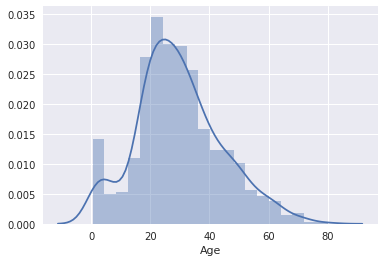

In [59]:
sns.distplot(train['Age'][~train['Age'].isnull()])

Да видим как изглежда дистрибуцията на годините след вкарването на новите данни.

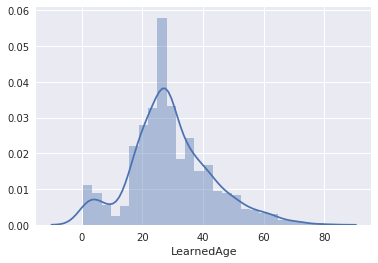

In [60]:
sns.distplot(train['LearnedAge'])

Изглежда сме добавили доста хора на по 25-30 години.

## Нека да видим зависимостите в числовите фийчъри 

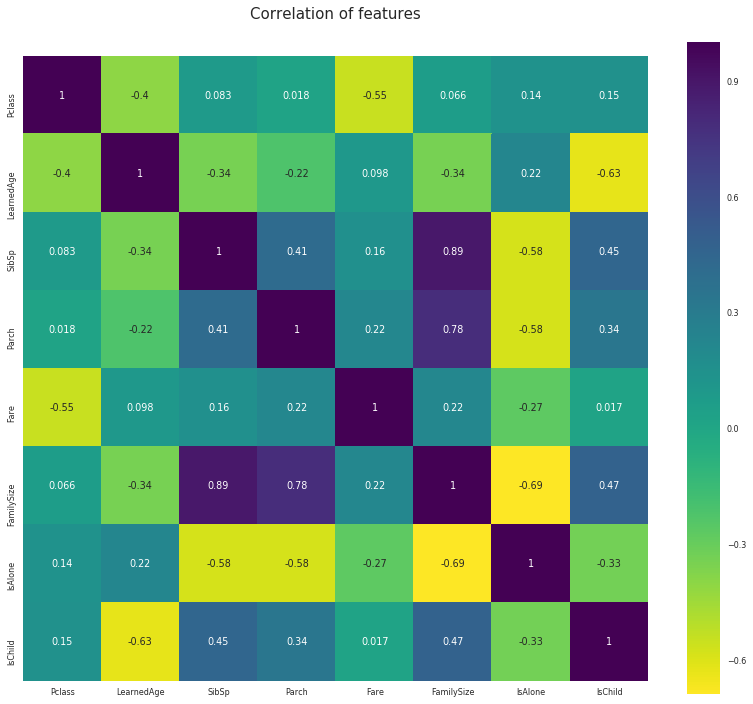

In [70]:
def corr_map(data_frame):
    plt.figure(figsize=(14, 12))
    plt.title('Correlation of features', y=1.05, size=15)
    sns.set(font_scale=0.8)
    sns.heatmap(data_frame.astype(float).corr(), square=True, annot=True, cmap=plt.cm.viridis_r)

numeric_cols = ['Pclass', 'LearnedAge', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'IsChild']
corr_map(train[numeric_cols])

# Създаване на pipeline за енкодване и скалиране на данните

In [64]:
transformer = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('LearnedAge')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler()),
        ])),
        ('is_alone', Pipeline([
            ('select', ItemSelector('IsAlone')),
        ])),
        ('is_child', Pipeline([
            ('select', ItemSelector('IsChild')),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('SibSp')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Parch')),
            ('scaler', StandardScaler()),
        ])),
        ('Fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', StringLabelBinerizer()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', StringLabelBinerizer()),
        ])),
    ])),
])

In [79]:
svc_model = SVC(random_state=88)
logistic_model = LogisticRegression(random_state=888)
forest_model = RandomForestClassifier(random_state=88)

X = transformer.fit_transform(train.drop(['Survived'], axis=1))
y = train['Survived']

scores = cross_val_score(svc_model, X, train['Survived'], cv=5)
print('SVC model', scores.mean())

scores = cross_val_score(logistic_model, X, train['Survived'], cv=5)
print('Logistic model', scores.mean())

scores = cross_val_score(forest_model, X, train['Survived'], cv=5)
print('Random forest model', scores.mean())

SVC model 0.826066827033
Logistic model 0.793494544091
Random forest model 0.805810084237


# Търсене на добри хиперпараметри

In [83]:
svc_model = SVC(random_state=88)
logistic_model = LogisticRegression(random_state=888)
forest_model = RandomForestClassifier(random_state=88)

cross_validation = StratifiedKFold(y, n_folds=5)

forest_params = {
    'max_depth' : [2, 4, 6, 8, 10],
    'n_estimators': [210, 220, 240, 280],
    'criterion': ['entropy', 'gini']
}

forest_grid_search = GridSearchCV(forest_model, param_grid=forest_params, cv=cross_validation)

forest_grid_search.fit(X, y)

print('Forest score', grid_search.best_score_)

NameError: name 'grid_search' is not defined

# Predictions from the model

In [ ]:
def save_predictions(model, test, file_name):
    predictions = model.predict(test)
    frame = pd.DataFrame({
        'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
        'Survived': predictions
    })
    frame = frame.set_index('PassengerId')
    frame.to_csv('~/data/' + file_name + '.csv')

In [ ]:
test.info()

In [ ]:
transformer.fit_transform(test)

In [ ]:
train.columns